In [15]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import ee
import geemap
from IPython.display import Image
ee.Initialize()

In [2]:
py_date = dt.datetime(2007, 7, 12)
start_date = ee.Date(py_date)
py_date = dt.datetime(2020, 7, 12)
end_date = ee.Date(py_date)

paracou = ee.Geometry.Polygon(
    [
        [
            [-52.96826251951243, 5.255075746627255],
            [-52.91770824399973, 5.255075746627255],
            [-52.91770824399973, 5.307808451724001],
            [-52.96826251951243, 5.307808451724001],
            [-52.96826251951243, 5.255075746627255],
        ]
    ]
)

In [3]:
#def addTime(image):
#    return image.addBands(image.metadata('system:time_start').divide(1000 * 60 * 60 * 24 * 365))

MODIS_EVI16 = (ee.ImageCollection('MODIS/MCD43A4_006_EVI')
                .filter(ee.Filter.date(start_date, end_date))
                .select('EVI'))

#MODIS_EVI16 = MODIS_EVI16.map(addTime)

def setProperty(image):
    dict = image.reduceRegion(ee.Reducer.mean(), paracou)
    return image.set(dict)


def get_date(image):
    date = ee.Feature(image.date().format('YYYY-MM-dd'))
    dict = ee.Dictionary({'date': date})
    return image.set(dict)


withMean = MODIS_EVI16.map(setProperty)
withDates = withMean.map(get_date)

EVI = withMean.aggregate_array('EVI').getInfo()
dates = withDates.aggregate_array('date').getInfo()


In [4]:
def EVI_dates(image):
    date = image.date().format('YYYY-MM-dd')
    dict = image.reduceRegion(ee.Reducer.mean(), paracou)
    dict2 = ee.Feature(None, dict.set('date', date))
    return dict2


In [5]:
#EVI_dates(MODIS_EVI16.first()).getInfo()
info = MODIS_EVI16.map(EVI_dates).getInfo()

In [157]:
EVI_local = ['hi']*len(info['features'])
for i in range(len(info['features'])):
    EVI_local[i] = info['features'][i]['properties']

In [135]:
EVI_local[150]

{'date': '2007-12-09'}

In [161]:
EVI_local = pd.DataFrame(EVI_local)
EVI_local['date'] = pd.to_datetime(EVI_local['date'], format = "%Y-%m-%d")

In [162]:
dates = pd.DatetimeIndex(EVI_local['date'])
dates

DatetimeIndex(['2007-07-12', '2007-07-13', '2007-07-14', '2007-07-15',
               '2007-07-16', '2007-07-17', '2007-07-18', '2007-07-19',
               '2007-07-20', '2007-07-21',
               ...
               '2020-06-28', '2020-06-29', '2020-06-30', '2020-07-01',
               '2020-07-02', '2020-07-03', '2020-07-04', '2020-07-05',
               '2020-07-06', '2020-07-07'],
              dtype='datetime64[ns]', name='date', length=4745, freq=None)

In [166]:
EVI = EVI_local['EVI']
EVI

0       0.486966
1       0.480691
2       0.484900
3       0.479179
4       0.479438
          ...   
4740    0.477957
4741    0.487097
4742    0.487443
4743    0.487546
4744    0.487846
Name: EVI, Length: 4745, dtype: float64

In [175]:
#EVI_local = pd.DataFrame(EVI_local['EVI'], EVI_local['date])
EVI_local.index = dates
EVI_local

,EVI,date
date,,
2007-07-12,0.486966,2007-07-12
2007-07-13,0.480691,2007-07-13
2007-07-14,0.484900,2007-07-14
2007-07-15,0.479179,2007-07-15
2007-07-16,0.479438,2007-07-16
...,...,...
2020-07-03,0.477957,2020-07-03
2020-07-04,0.487097,2020-07-04
2020-07-05,0.487443,2020-07-05


In [178]:

EVI = EVI_local['EVI']

In [203]:
EVI.values

array([0.48696585, 0.48069053, 0.48489951, ..., 0.48744334, 0.48754557,
       0.48784638])

In [204]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Multiplicative Decomposition 
result_mul = seasonal_decompose(EVI_local['EVI'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(EVI_local['EVI'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

ModuleNotFoundError: No module named 'statsmodels'

In [111]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [113]:
EVI_local.index.values

array([   0,    1,    2, ..., 4742, 4743, 4744])

In [181]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [96]:
EVI_local

,EVI,date
0,0.486966,2007-07-12
1,0.480691,2007-07-13
2,0.484900,2007-07-14
3,0.479179,2007-07-15
4,0.479438,2007-07-16
...,...,...
4740,0.477957,2020-07-03
4741,0.487097,2020-07-04
4742,0.487443,2020-07-05
4743,0.487546,2020-07-06


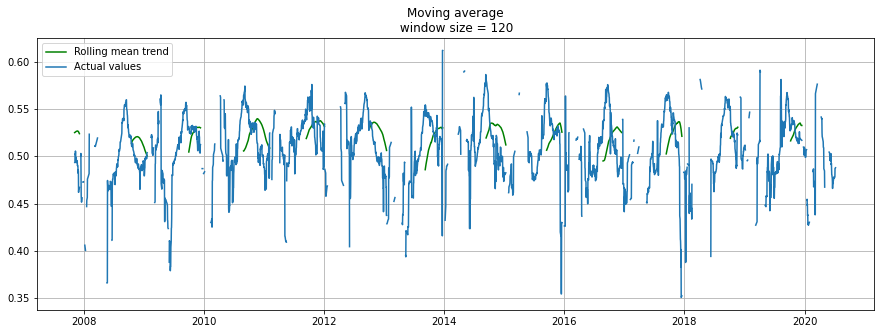

In [183]:
plotMovingAverage(EVI, 120)

In [186]:
EVI.name = 'EVI'

In [188]:
type(EVI)

pandas.core.series.Series

In [191]:
type(EVI_local['date'])

pandas.core.series.Series

In [190]:
import matplotlib
import numpy as np

z = np.polyfit(EVI_local['EVI'], EVI_local['date'], 1)
p = np.poly1d(z)
pylab.plot(a['date'],p,"r--")

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('float64')

In [28]:
def ymdList(imgcol):
    def iter_func(image, newlist):
        date = ee.Number.parse(image.date().format("YYYYMMdd"));
        newlist = ee.List(newlist);
        return ee.List(newlist.add(date).sort())
    ymd = imgcol.iterate(iter_func, ee.List([]))
    return list(ee.List(ymd).reduce(ee.Reducer.frequencyHistogram()).getInfo().keys())

dates = ymdList(MODIS_EVI16)
len(dates)

2920

In [64]:
print(MODIS_EVI16.first().propertyNames().getInfo())
date = ee.Date(MODIS_EVI16.first().get('system:time_start'))
print(date.getInfo())

['system:time_start', 'system:time_end', 'system:version', 'system:id', 'system:index', 'system:bands', 'system:band_names']
{'type': 'Date', 'value': 963360000000}


In [8]:
#ee.Geometry.Rectangle([-84.6, -55.9, -32.9, 15.7])
url = image1.getThumbURL({
  'min': 0,
  'max': 1,
  'palette': ['00A600','63C600','E6E600','E9BD3A','ECB176','EFC2B3','F2F2F2'],
  'dimensions': 500,
  'region': region,
})
url

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d05bc89213fd70a505de03e2dc1fcb11-7aeca0c8352333e4ce41d3bf91b0d57d:getPixels'

In [9]:
Image(url=url)

In [85]:
import geemap

In [86]:
Map = geemap.Map(center=[40,-100], zoom =4)
Map.addLayer(image1)

In [87]:
Map


Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…